# Dark Sky Positions direct from Catalogue

In [81]:
import matplotlib.pyplot as plt
from astropy.io import fits as fits

import pkg_resources
pkg_resources.require("numpy==1.26.3")
import numpy as np

from dl import queryClient as qc
import pandas as pd

In [82]:
# timer function
import functools
import time

def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer


## Querying tractor catalogue for one degree squares

In [83]:
def query_tractor(ra, dec, dist=1.0):
    """Queries the Astro Data Lab for the ra, dec and mag_g of the objects within a square of side length (dist).     
    dist is in degrees
    """
    # Bounds of the square we are querying objects for
    ra_min=ra
    ra_max = ra + dist
    dec_min=dec
    dec_max = dec + dist

    query = f"""
    SELECT ra, dec, mag_g
    FROM ls_dr10.tractor_s
    WHERE ra >= ({ra_min}) AND ra < ({ra_max})
    AND dec >= ({dec_min}) AND dec < ({dec_max})
    AND mag_g <= 21 AND mag_g >= 16
    """
    
    # check if this completes successfuly
    brick_info = qc.query(sql=query, fmt="pandas")
    return brick_info, [ra_min, ra_max, dec_min, dec_max]

## Get bitmask info

In [84]:
def load_mask_data(index=0, load_all=False):
    """Load a desired mask data file by index, or just download all five. 
    Returns a pandas Dataframe with columns 'ra', 'dec', 'radius'
    """
    
    # load all
    if load_all:
        all_masks = []
        for i in range(5):
            
            with np.load(f"mask_data_{i}.npz", mmap_mode='r') as mask_data:
                mask_array = mask_data['arr_0']
                mask_array_byteswap = mask_array.byteswap().newbyteorder()
                masked_stars = pd.DataFrame(mask_array_byteswap)
                all_masks.append(masked_stars)
        return pd.concat(all_masks, ignore_index=True)

    # load single index
    with np.load(f"mask_data_{index}.npz", mmap_mode='r') as mask_data:
        mask_array = mask_data['arr_0']
        mask_array_byteswap = mask_array.byteswap().newbyteorder()
        masked_stars = pd.DataFrame(mask_array_byteswap)

    return masked_stars
    

## Process mask and catalog data together

In [103]:
# masking for low magnitude objects

@timer
def mask_radius(mag_g, mask_radius=20):
    return (mask_radius/3600) + 1630./3600. * 1.396**(-mag_g)

In [116]:
# combine mask and star data

@timer
def combine_data(masked_stars, catalog_stars, coords, mask_minimum):
    # coords = [ra-map_dist, ra+map_dist, dec-map_dist, dec+map_dist]
    
    # cut masked stars to only use the same area as catalog_stars
    masked_box = masked_stars.query('(@coords[0] < ra < @coords[1]) and (@coords[2] < dec < @coords[3])')
    
    # apply buffer radius to mask and star data
    masked_box['radius'] = masked_box['radius'] + (mask_minimum / 3600.)
    catalog_stars['radius'] = mask_radius(catalog_stars['mag_g'], mask_minimum)
    
    # remove g mag
    catalog_stars = catalog_stars.drop('mag_g', axis=1)
    
    # combine catalog + mask
    all_stars = pd.concat([masked_box, catalog_stars]).reset_index(drop=True)
    # all_stars
    # print(repr(all_stars))
    # print(catalog_stars.columns)
    # print(masked_stars.columns)
    
    
    # fig, ax = plt.subplots()
    # ax.plot(all_stars['ra'], all_stars['dec'], '.')
    # plt.show()
    return all_stars

Loading masked star data....
Elapsed time: 2.6304 seconds
Querying the tractor catalog for stars from RA(3, 4.0) to DEC(-4, -3.0)...
Elapsed time: 7.6655 seconds
Elapsed time: 0.0003 seconds
            ra       dec    radius
0     3.023647 -3.096134  0.007073
1     3.098122 -3.045235  0.003555
2     3.148746 -3.031619  0.003386
3     3.043816 -3.120869  0.003328
4     3.242083 -3.033617  0.002973
...        ...       ...       ...
2717  3.849236 -3.010013  0.006125
2718  3.939230 -3.006258  0.006656
2719  3.966327 -3.009517  0.005982
2720  3.967780 -3.009232  0.006012
2721  3.979773 -3.002734  0.007363

[2722 rows x 3 columns]


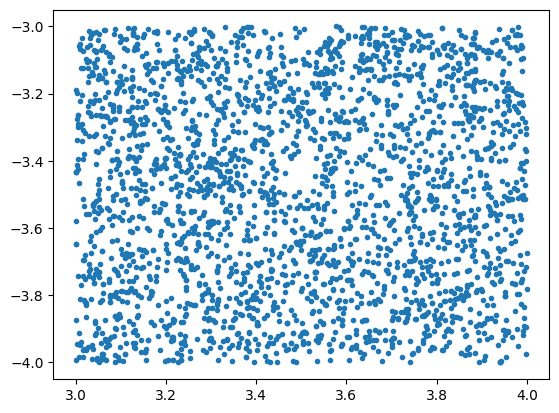

Elapsed time: 0.3303 seconds
Elapsed time: 10.6267 seconds


In [117]:
generate_dark_sky_catalogue(3,-4)

## Segmentation map

Start with OG seg map, without bitmask stuff yet

In [87]:
def full_df(masked_stars, tractor_df, coords):
    one_deg_sq = masked_stars.query(' (ra >' + str(coords[0]) + ') & (ra <' + str(coords[1]) + ') & (dec >' + str(coords[2]) + ') & (dec <' + str(coords[3]) + ')' )
    df = pd.concat([tractor_df,one_deg_sq], axis=0)
    df = df.drop('mag_g', axis=1)
    return df

## Segmentation map

In [88]:
def seg_map(df, dim, coords):

    array = np.zeros((dim, dim), dtype=int)

    ra_pix = np.round((df['ra'] - coords[0]) * dim).astype(int) - 1
    dec_pix = np.round((df['dec'] - coords[2]) * dim ).astype(int) - 1
    rad_pix = np.ceil(df['radius']*dim).astype(int)

    for y, x, r in zip(ra_pix,dec_pix,rad_pix):
        ra_max = x + r if x+r <= dim else dim
        ra_min = x - r if x-r >= 0 else 0
        dec_max = y + r if y+r <= dim else dim
        dec_min = y - r if y-r >= 0 else 0

        for i in range(ra_min,ra_max):
            for j in range(dec_min,dec_max):
                if ((i-x)**2 + (j-y)**2) <= r**2:
                    array[i,j] = 1

    return array, [ra_pix, dec_pix, rad_pix]

In [89]:
def define_grid(dim, fov=45):
    gridlines = np.arange(0, dim+1, (fov/3600 * dim))
    return gridlines

In [90]:
def find_dark_regions(array, gridlines):

    # calculating and storing the centre of each dark coord
    centers = []

    for i in range(len(gridlines[:-1])):
        centers.append(int((gridlines[i] + gridlines[i+1])/2 + 0.5))

    x_cen, y_cen = np.meshgrid(centers, centers)

    dark_regions = []

    for i in range(len(gridlines) - 1):
        for j in range(len(gridlines) - 1):
            x_start, x_end = (gridlines[i]).astype(int), (gridlines[i + 1]).astype(int)
            y_start, y_end = (gridlines[j]).astype(int), (gridlines[j + 1]).astype(int)
            
            if np.all(array[y_start:y_end, x_start:x_end] == 0):
                dark_regions.append([x_cen[j, i], y_cen[j, i]])

    dr_trans = np.array(dark_regions).transpose()

    return dr_trans, dark_regions

In [91]:
def create_plot(array, coords, pix_coords, gridlines, dim, dr_trans):

    # Creating exclusion map with grid
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    plt.imshow(array, origin = 'lower', cmap='gray', vmin=0, vmax=1)

    positions = np.linspace(0,dim,5)
    x_labels = np.linspace(coords[0],coords[1],5)
    y_labels = np.linspace(coords[2],coords[3],5)

    ax.set_xticks(positions, x_labels)
    ax.set_yticks(positions, y_labels)    

    plt.vlines(gridlines, min(pix_coords[1]), max(pix_coords[1]), color='red', linewidth=1)
    plt.hlines(gridlines, min(pix_coords[0]), max(pix_coords[0]), color= 'red', linewidth=1)

    plt.plot(dr_trans[0], dr_trans[1], 'rx', markersize=10)

    plt.tight_layout()
    plt.margins(0)
    plt.show()

    return

In [92]:
def create_data_frame(dark_regions, coords, dim):
    dark_ra = []
    dark_dec = []

    for i in dark_regions:
        ra = i[0] / (dim) + coords[0]
        dec = i[1] / (dim) + coords[2]
        dark_ra.append(ra)
        dark_dec.append(dec)

    dark_catalogue = pd.DataFrame({'ra':dark_ra, 'dec':dark_dec})
    return dark_catalogue

In [118]:
def generate_dark_sky_catalogue(ra, dec, dist=1.0, fov_radius=20, masked_stars=load_mask_data(index=0,load_all=True), fov=45):
    
    dim = int((3600*4) * dist)
    
    dim = int((3600*4) * map_dist)
    
    # load masked data
    print("Loading masked star data....")
    masked_stars = load_mask_data(load_all=True)
    
    print(f"Querying the tractor catalog for stars from RA({ra}, {ra+query_dist}) to DEC({dec}, {dec+query_dist})...")
    tractor_df = query_tractor(ra, dec, query_dist)
    
    # concatenate data
    coords = [ra, ra+map_dist, dec, dec+map_dist]
    combine_data(masked_stars, tractor_df, coords, mask_min_radius)

    return
    print("Calculating masking radii for catalog stars....")
    tractor_df = mask_radius(tractor_df, mask_min_radius)
    
    print("Combining mask and queried stars...")
    
    df = full_df(masked_stars, tractor_df, coords)

    array, pix_coords = seg_map(df, dim, coords)

    gridlines = define_grid(dim, fov)

    dr_trans, dark_regions = find_dark_regions(array, gridlines)

    print("Plotting dark regions...")
    create_plot(array, coords, pix_coords, gridlines, dim, dr_trans)

    dark_catalogue = create_data_frame(dark_regions, coords, dim)

    return dark_catalogue

Loading masked star data....
Elapsed time: 2.6674 seconds
Querying the tractor catalog for stars from RA(3, 4.0) to DEC(-4, -3.0)...
Elapsed time: 7.8067 seconds


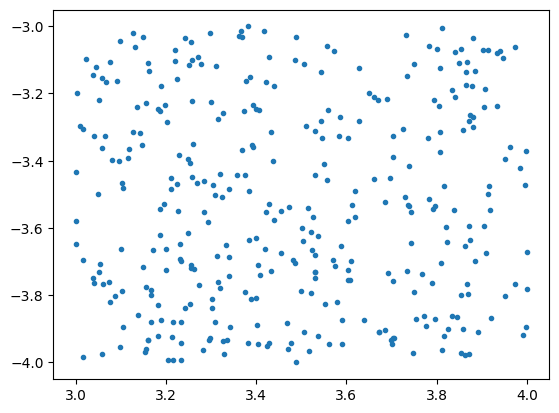

Calculating masking radii for catalog stars....
Elapsed time: 0.0010 seconds
Combining mask and queried stars...
Elapsed time: 0.1237 seconds
Creating segmentation map...
Elapsed time: 49.7553 seconds
Defining grid lines...
Elapsed time: 0.0001 seconds
Finding dark regions...
Elapsed time: 0.3383 seconds
Plotting dark regions...


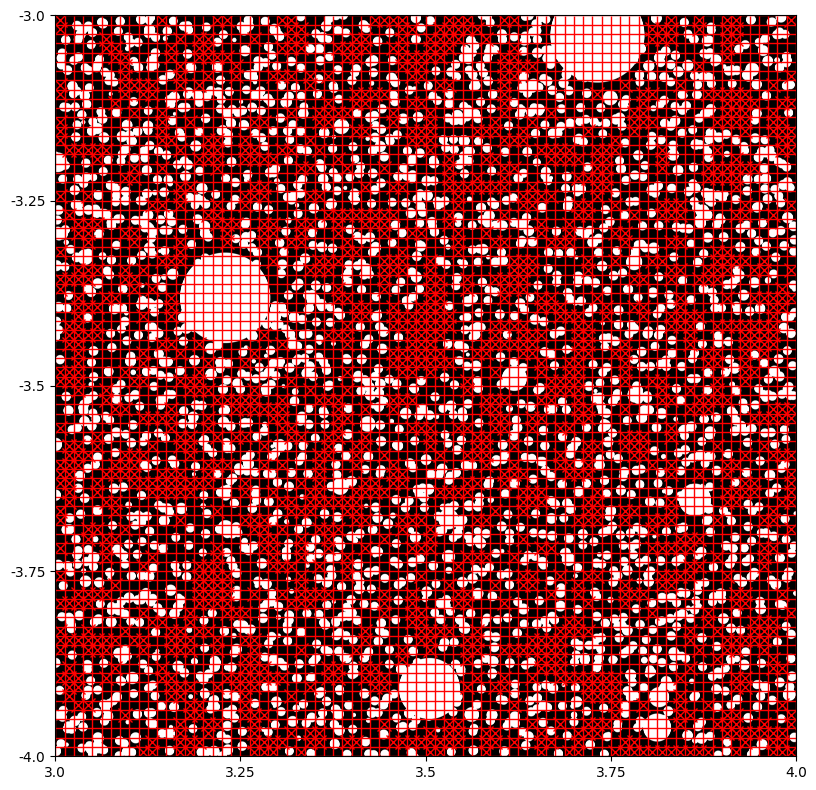

Elapsed time: 5.2431 seconds
Converting dark regions to coordinates...
Elapsed time: 0.0009 seconds
Done!
Elapsed time: 66.2751 seconds


,ra,dec
0,3.00625,-3.89375
1,3.00625,-3.85625
2,3.00625,-3.84375
3,3.00625,-3.83125
4,3.00625,-3.79375
...,...,...
1503,3.99375,-3.16875
1504,3.99375,-3.15625
1505,3.99375,-3.11875
1506,3.99375,-3.08125


In [94]:
dark_catalogue = generate_dark_sky_catalogue(3,-4)
dark_catalogue

In [33]:
masked_stars = load_mask_data(index=0,load_all=True)
masked_stars

,ra,dec,radius
0,90.172277,-66.053705,0.012262
1,89.994336,-66.102438,0.010412
2,89.961793,-66.015076,0.008367
3,90.243334,-66.067733,0.007265
4,90.122942,-66.019305,0.005788
...,...,...,...
19204371,231.941317,6.072278,0.002702
19204372,231.850394,6.028061,0.002686
19204373,231.856376,6.113636,0.002609
19204374,231.755958,6.051862,0.002419


In [34]:
# sort by radius
radius_sorted = masked_stars.sort_values(by='radius', ascending=False)
radius_sorted = radius_sorted.reset_index(drop=True)
# radius_sorted.query('radius > 0.2 and overlap==True')

# apply a buffer of a minimum exclusion zone radius to all masks (arcsec)
exclusion_minimum = 20
radius_sorted['radius'] = radius_sorted['radius'] + (20 / 3600)

# convert to pixel radius
dim = 3600 * 4
radius_sorted['rad_pix'] = np.ceil(radius_sorted['radius']*dim).astype(int)

# find max and min ra/dec corresponding to the mask of star
radius_sorted['max_ra'] = radius_sorted['ra'] + radius_sorted['radius']
radius_sorted['min_ra'] = radius_sorted['ra'] - radius_sorted['radius']
radius_sorted['max_dec'] = radius_sorted['dec'] + radius_sorted['radius']
radius_sorted['min_dec'] = radius_sorted['dec'] - radius_sorted['radius']

# separate array for radii that go above 1-degree integer RA/DEC bounds
expression = '(max_ra > ceil(ra)) | (min_ra < floor(ra)) | (max_dec > ceil(dec)) | (min_dec < floor(dec))'

# boolean in same array to convey the same info
radius_sorted['overlap'] = radius_sorted.eval(expression)

radius_sorted

,ra,dec,radius,rad_pix,max_ra,min_ra,max_dec,min_dec,overlap
0,95.987878,-52.695718,0.571576,8231,96.559453,95.416302,-52.124142,-53.267294,True
1,213.918115,19.187273,0.434656,6260,214.352771,213.483459,19.621929,18.752617,True
2,78.634464,-8.201639,0.417979,6019,79.052443,78.216484,-7.783660,-8.619618,True
3,258.661928,14.390257,0.398903,5745,259.060831,258.263025,14.789160,13.991354,True
4,114.827242,5.227508,0.393789,5671,115.221031,114.433453,5.621297,4.833719,True
...,...,...,...,...,...,...,...,...,...
19204371,90.263031,-37.071822,0.005556,80,90.268586,90.257475,-37.066267,-37.077378,False
19204372,284.899412,-46.645754,0.005556,80,284.904967,284.893856,-46.640198,-46.651309,False
19204373,20.076793,21.372984,0.005556,80,20.082348,20.071237,21.378540,21.367429,False
19204374,56.351719,-27.862083,0.005556,80,56.357275,56.346163,-27.856527,-27.867638,False


Finding everything within the square RA=(3, 4) and DEC=(-4, -3)
min ra: 2.984696008407812
min dec: -4.008426710894652
max ra: 4.009241896688543
max dec: -2.958397070947133


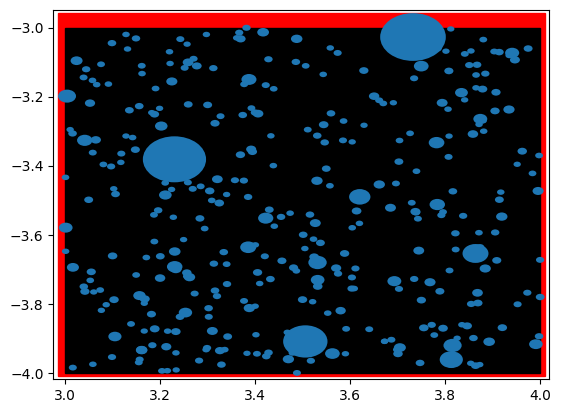

(2.984696008407812, -4.008426710894652, 4.009241896688543, -2.958397070947133)

In [35]:
def find_overlapping_extent(ra, dec):
    # grab everything in a 1 degree square
    print(f"Finding everything within the square RA=({ra}, {ra+1}) and DEC=({dec}, {dec+1})")
    
    degree_masks = radius_sorted.query(f'({ra} < ra < {ra+1}) & ({dec} < dec < {dec+1})')

    min_ra = degree_masks['min_ra'].min()
    min_dec = degree_masks['min_dec'].min()
    max_ra = degree_masks['max_ra'].max()
    max_dec = degree_masks['max_dec'].max()

    print(f"min ra: {min_ra}")
    print(f"min dec: {min_dec}")
    print(f"max ra: {max_ra}")
    print(f"max dec: {max_dec}")

    fig, ax = plt.subplots()
    r = plt.Rectangle(xy=(ra, dec), width=1, height=1, hatch='/', color='k')
    r2 = plt.Rectangle(xy=(min_ra, min_dec), width=max_ra-min_ra, height=max_dec-min_dec, color='r')
    ax.add_patch(r2)
    ax.add_patch(r)
    for ra, dec, rad in zip (degree_masks['ra'], degree_masks['dec'], degree_masks['radius']):
        c = plt.Circle(xy=(ra, dec), radius=(rad))
        ax.add_patch(c)
        
    ax.set(xlim=(min_ra-0.01, max_ra+0.01), ylim=(min_dec-0.01, max_dec+0.01))
    plt.show()
    
    return min_ra, min_dec, max_ra, max_dec

find_overlapping_extent(3, -4)